## Social neuroscience with CEBRA

### Author: Maria Kesa

The dataset for this notebook comes from a summer school held in Caltech: https://github.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/blob/main/07_10_23_day1_ethics_regression/code/diy_notebooks/dimensionality_reduction.ipynb
The author of the notebook above is Sabera Talukber. Check out the notebook for exercises on applying PCA to the same data-- you can compare PCA and CEBRA:-)

I think the data is a subset of the data used in the study "Social behaviour shapes hypothalamic neural ensemble representations of conspecific sex", Remedios et al, Nature 2017. 

In this particular subset of the data neural activity in the hypothalamus of a male mouse was measured while either a female or a male mouse was introduced into the same cage. 

<center><img src="https://drive.google.com/uc?export=view&id=1ts_czT8HluZHqnr1cIUj1BNkwRfjWZoj
" alt="EMFigure" width="500"><center>
    
(Image from the the github notebook above.)     

In [58]:
!wget https://raw.githubusercontent.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/main/07_10_23_day1_ethics_regression/data/hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true
!mv hypothalamus_calcium_imaging_remedios_et_al.mat\?raw\=true hypothalamus_calcium_imaging_remedios_et_al.mat

--2023-08-22 20:46:51--  https://raw.githubusercontent.com/cheninstitutecaltech/Caltech_DATASAI_Neuroscience_23/main/07_10_23_day1_ethics_regression/data/hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8000::154, 2606:50c0:8001::154, 2606:50c0:8002::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8000::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 16508091 (16M) [application/octet-stream]
Saving to: ‘hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true’

hypothalamus_calciu 100%[===================>]  15,74M  22,1MB/s    in 0,7s    

2023-08-22 20:46:53 (22,1 MB/s) - ‘hypothalamus_calcium_imaging_remedios_et_al.mat?raw=true’ saved [16508091/16508091]



When the goal is to embed a dataset for data visualization and exploration, one approach is to embed the entire dataset and visualize it. However, this does not evaluate the ability of the embedding algorithm to generalize to novel data. A stronger test of the capabilities of the algorithm is splitting the data into a training and test set, using the training data to learn an embedding function and then apply this function to test data. Here we take exactly this approach. CEBRA uses temporal information and therefore randomply picking data points for the train and test set is not the best option. Here we split the data so that the training data is fully contiguous. You can experiment with different methods to split the data. While playing around with the algorithm, I found that randomly sampling train and test points or even splitting in an alternating fashion with small contiguous blocks, destroys the patterns found in CEBRA embeddings.

In [57]:
from cebra import CEBRA
from scipy.io import loadmat
import numpy as np
import seaborn as sns


hypothalamus_data = loadmat('hypothalamus_calcium_imaging_remedios_et_al.mat')

def train_test_split(hypothalamus_data):
    '''
    In the current scheme, we split the data when a 
    female was in the cage with the measured mouse
    and when a male was in the cage with a measured mouse
    both in half and take contiguous halves as the training
    set (see plot below). 
    It is possible to use other strategies for train/test split.
    
    Indicator 0 refers to train portion and 1 to the test portion.
    '''
    
    neural_data = hypothalamus_data['neural_data'].T
    attack_vector = hypothalamus_data['attack_vector'].flatten()
    sex_vector = hypothalamus_data['sex_vector'].flatten()
    
    train_test_indicator=np.zeros((neural_data.shape[0],))
    
    #Split data when the cage mate is female 
    female_mate = np.where(sex_vector.flatten()==1)[0]
    male_mate = np.where(sex_vector.flatten()==0)[0]
    n_train_female = female_mate.shape[0]//2
    split_point_f = female_mate[n_train_female]
    n_train_male = male_mate.shape[0]//2
    split_point_m= male_mate[n_train_male]
    #Assign test splits, the training set has values zero
    train_test_indicator[:split_point_f]=1
    train_test_indicator[split_point_m:]=1
    
    train_inds=np.where(train_test_indicator==0)[0]
    test_inds=np.where(train_test_indicator==1)[0]
    neural_data_train=neural_data[train_inds]
    neural_data_test=neural_data[test_inds]
    sex_vector_train=sex_vector[train_inds]
    sex_vector_test=sex_vector[test_inds]
    attack_vector_train=attack_vector[train_inds]
    attack_vector_test=attack_vector[test_inds]
    
    print('Calcium imaging data shape: ', neural_data.shape)
    print('Training set shape: ', neural_data_train.shape)
    print('Test set shape: ', neural_data_test.shape)
    print('Train/test split indicator shape', train_test_indicator.shape)
    
    return {'neural_data' : {'train': neural_data_train, 'test': neural_data_test, 'full': neural_data}, 
            'sex_vector': {'train': sex_vector_train, 'test': sex_vector_test, 'full': sex_vector},
            'attack_vector': {'train': attack_vector_train, 'test': attack_vector_test, 'full': attack_vector},
           'train_test_indicator': train_test_indicator, 'split_points': [split_point_m, split_point_f]}

data = train_test_split(hypothalamus_data)

Calcium imaging data shape:  (18561, 115)
Training set shape:  (9280, 115)
Test set shape:  (9281, 115)
Train/test split indicator shape (18561,)


<IPython.core.display.Javascript object>


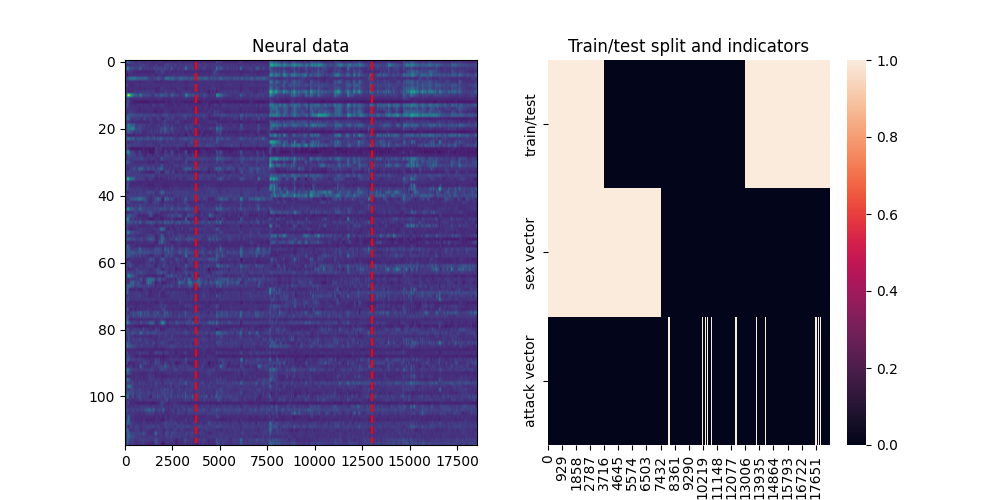

In [59]:
def plot_test_train_split(data):
    experiment_indicators=np.vstack((data['train_test_indicator'],data['sex_vector']['full'],data['attack_vector']['full']))
    e_n=['train/test', 'sex vector', 'attack vector']
    fig, axes = plt.subplots(1, 2, figsize=(10, 5))

    # Plot the neural_data as an image with adjusted aspect ratio
    img = axes[0].imshow(neural_data, aspect='auto')  # 'auto' adjusts aspect ratio

    axes[0].set_title('Neural data')

    # Add vertical lines at split_points
    for split_point in data['split_points']:
        axes[0].vlines(split_point, ymin=0, ymax=neural_data.shape[0]-1, colors='red', linestyles='dashed')


    img2 = sns.heatmap(experiment_indicators, yticklabels=e_n)  # 'auto' adjusts aspect ratio

    axes[1].set_title('Train/test split and indicators')
    
plot_test_train_split(data)

In [60]:
cebra_model = CEBRA(
    model_architecture = "offset10-model",
    batch_size = 1024,
    temperature_mode="auto",
    learning_rate = 0.001,
    max_iterations = 100,
    time_offsets = 10,
    output_dimension = 3,
    device = "cuda_if_available",
    verbose = False
)

cebra_model.fit(data['neural_data']['train'])

CEBRA(batch_size=1024, learning_rate=0.001, max_iterations=100,
      model_architecture='offset10-model', output_dimension=3,
      temperature_mode='auto', time_offsets=10)

<IPython.core.display.Javascript object>


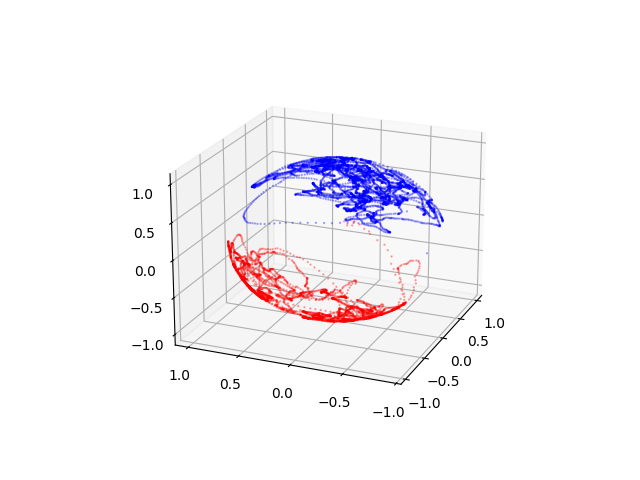

In [62]:
import cebra
import matplotlib.pyplot as plt

embedding=cebra_model.transform(data['neural_data']['test'])
%matplotlib notebook
fig = plt.figure()
ax = plt.axes(projection='3d')

# Enter code here:
embedding1 = embedding[:,0]
embedding2 = embedding[:,1]
embedding3 = embedding[:,2]

ax.scatter3D(embedding1, embedding2, embedding3,c=data['sex_vector']['test'],cmap='bwr',alpha=0.3,s=0.5);
plt.show()


We see that CEBRA is able to separate out the different dynamical modes in the hypothalamus when a female or a male mouse is in the cage with the measured mouse even without using a supervision signal from auxiliary data and that the function learned by the algorithm on the training data generalizes to test data. The plot gives a hint that decoding the sex of the other animal should work really well. Further experiments are left to the reader:-)